In [67]:
import json
from pathlib import Path
import pickle
from pprint import pprint
import random
import time

from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from musixmatch import Musixmatch
import requests

%matplotlib inline

## Get the top 200 most played tracks daily on Spotify in the US from 20170101 to 20180101

In [2]:
headers = {
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.75 Safari/537.36'
}

url = 'https://spotifycharts.com/regional/{region}/{span}/{date}'

In [3]:
json_path = Path('./spotify_top_200_20170101-20180101.json')

if json_path.exists():
    print('Loading from disk.')
    with json_path.open() as f:
        stats = json.load(f)
else:
    checked = set()
    errors = set()
    stats = {}

    with requests.session() as s:
        s.headers.update(headers)
        for date in pd.date_range(start='20170101', end='20180101'):
            lst = []
            date = date.strftime('%Y-%m-%d')
            r = s.get(url.format(region='us', span='daily', date=date)).text
            soup = bs(r)
            try:
                table = soup.select('.chart-table tbody')[0]
            except IndexError as e:
                print(e, date)
                errors.add(date)
            else:
                rows = table.select('tr')
                for row in rows:
                    position = row.select('.chart-table-position')[0].text
                    song, artist = row.select('.chart-table-track')[0].text.strip().split('\n')
                    artist = artist[3:]  # ignore 'by'
                    streams = row.select('.chart-table-streams')[0].text
                    lst.append({
                        'position': position,
                        'song': song,
                        'artist': artist,
                        'streams': streams
                    })
                stats[date] = lst
                checked.add(date)
                time.sleep(random.randint(1, 3))

    with open('spotify_top_200_20170101-20180101.json', 'w') as f:
        json.dump(stats, f, ensure_ascii=False, indent=4)

Loading from disk.


In [6]:
# Top 200 songs in the US on Spotify on 20170101 
stats['2017-01-01']

[{'position': '1',
  'song': 'Bad and Boujee (feat. Lil Uzi Vert)',
  'artist': 'Migos',
  'streams': '1,371,493'},
 {'position': '2',
  'song': 'Fake Love',
  'artist': 'Drake',
  'streams': '1,180,074'},
 {'position': '3',
  'song': 'Starboy',
  'artist': 'The Weeknd',
  'streams': '1,064,351'},
 {'position': '4',
  'song': 'Closer',
  'artist': 'The Chainsmokers',
  'streams': '1,010,492'},
 {'position': '5',
  'song': 'Black Beatles',
  'artist': 'Rae Sremmurd',
  'streams': '874,289'},
 {'position': '6',
  'song': 'Broccoli (feat. Lil Yachty)',
  'artist': 'DRAM',
  'streams': '763,259'},
 {'position': '7',
  'song': 'One Dance',
  'artist': 'Drake',
  'streams': '753,150'},
 {'position': '8',
  'song': 'Caroline',
  'artist': 'Aminé',
  'streams': '714,839'},
 {'position': '9',
  'song': 'Let Me Love You',
  'artist': 'DJ Snake',
  'streams': '690,483'},
 {'position': '10',
  'song': 'Bounce Back',
  'artist': 'Big Sean',
  'streams': '682,688'},
 {'position': '11',
  'song': 'I 

In [57]:
# Some dates are missing from the database.
errors

{'2017-05-30',
 '2017-05-31',
 '2017-06-02',
 '2017-07-20',
 '2017-07-21',
 '2017-07-22',
 '2017-07-23',
 '2017-11-09',
 '2017-11-10',
 '2017-11-11',
 '2017-11-12',
 '2017-11-13',
 '2017-11-14'}

## Use Musixmatch database to get metadata for each song

In [99]:
# Example
m = Musixmatch('<key>')
s = m.track_search(q_track='starboy', q_artist='the weeknd', page_size=10, page=1, s_track_rating='desc')
s

{'message': {'header': {'status_code': 200,
   'execute_time': 0.022153854370117,
   'available': 4},
  'body': {'track_list': [{'track': {'track_id': 114837357,
      'track_name': 'Starboy',
      'track_name_translation_list': [],
      'track_rating': 83,
      'commontrack_id': 63309876,
      'instrumental': 0,
      'explicit': 1,
      'has_lyrics': 1,
      'has_subtitles': 1,
      'has_richsync': 1,
      'num_favourite': 26808,
      'album_id': 23977356,
      'album_name': 'Starboy',
      'artist_id': 32104638,
      'artist_name': 'The Weeknd feat. Daft Punk',
      'track_share_url': 'https://www.musixmatch.com/lyrics/The-Weeknd-feat-Daft-Punk/Starboy?utm_source=application&utm_campaign=api&utm_medium=',
      'track_edit_url': 'https://www.musixmatch.com/lyrics/The-Weeknd-feat-Daft-Punk/Starboy/edit?utm_source=application&utm_campaign=api&utm_medium=',
      'restricted': 0,
      'updated_time': '2016-09-22T10:10:59Z',
      'primary_genres': {'music_genre_list': [{'

In [5]:
# Total number of unique songs
songs = {(track['song'], track['artist']) for day in stats for track in stats[day]}
print(f'Total no. of unique songs: {len(songs)}')

Total no. of unique songs: 1618


In [115]:
meta_path = Path('./spotify_meta.pkl')
if meta_path.exists():
    print('Loading from disk.')
    with meta_path.open('rb') as fp:
        meta_dict = pickle.load(fp)

errors = set()
checked = set()
meta_dict = {}

for idx, (song, artist) in enumerate(songs, 1):
    r = m.track_search(q_track=song, q_artist=artist, page_size=10, page=1, s_track_rating='desc')
    if r['message']['header']['status_code'] != 200:
        print(f'Error for {song} by {artist}')
        errors.add(track)
        continue
    else:
        try:
            meta = r['message']['body']['track_list'][0]['track']
        except IndexError as e:
            print(e, song, artist)
            errors.add((song, artist))
        else:
            meta_dict[(song, artist)] = meta
            checked.add((song, artist))
    if idx % 25 == 0:
        print('Sleeping')
        time.sleep(random.randint(1, 3))

with open('spotify_meta.pkl', 'wb') as f:
    pickle.dump(meta_dict, f)

list index out of range Cake - Challenge Version Flo Rida
list index out of range I Don’t Wanna Live Forever (Fifty Shades Darker) - From "Fifty Shades Darker (Original Motion Picture Soundtrack)" ZAYN
list index out of range Lose Yourself - From "8 Mile" Soundtrack Eminem
list index out of range Shining (feat. Beyoncé & Jay-Z) DJ Khaled
Sleeping
list index out of range playboy shit (feat. lil aaron) blackbear
list index out of range Real Thing (feat. Future) Tory Lanez
list index out of range Tip Toe (feat. French Montana) Jason Derulo
list index out of range Need Me (feat. Pink) Eminem
Sleeping
list index out of range gucci linen (feat. 2 Chainz) blackbear
Sleeping
list index out of range Fuck Love (feat. Trippie Redd) XXXTENTACION
list index out of range Tone it Down (feat. Chris Brown) Gucci Mane
list index out of range River - Recorded At RAK Studios, London Sam Smith
Sleeping
list index out of range Tragic Endings (feat. Skylar Grey) Eminem
Sleeping
list index out of range Colomb

list index out of range Crew (feat. Brent Faiyaz & Shy Glizzy) GoldLink
Sleeping
list index out of range Prayers Up (feat. Travis Scott & A-Trak) Calvin Harris
list index out of range Summer Friends (feat. Jeremih & Francis & The Lights) Chance the Rapper
Sleeping
Sleeping
list index out of range Mistletoe And Holly - Remastered 1999 Frank Sinatra
Sleeping
list index out of range OK (feat. Lil Pump) Smokepurpp
Sleeping
list index out of range Neon Guts (feat. Pharrell Williams) Lil Uzi Vert
list index out of range Sway (feat. Quavo & Lil Yachty) NexXthursday
Sleeping
list index out of range How Long (feat. French Montana) - Remix Charlie Puth
list index out of range Nowhere Fast (feat. Kehlani) Eminem
Sleeping
list index out of range Love U Better (feat. Lil Wayne & The-Dream) Ty Dolla $ign
list index out of range ...Baby One More Time - Recorded at Spotify Studios NYC Ed Sheeran
Sleeping
list index out of range T-Shirt (Spotify Mix) - Recorded at Spotify Studios NYC Migos
list index o

In [124]:
len(errors)

126

Some trouble getting meta data. Probably because of the different formats Spotify and Musixmatch store their data. But not too many misses!

## Most popular genres?

In [88]:
def add_meta(track, meta_dict):
    song = track['song']
    artist = track['artist']
    meta = meta_dict.get((song, artist))
    if not meta:
        print(f'Metadata not found for: {song} by {artist}')
    track['meta'] = meta
    return track

def get_genre_pop_counts(stats, sep=False):
    genre_counts = {}
    for date in stats:
        for track in stats[date]:
            if not track['meta']:
                continue
                
            position = track['position']
            genre_list = track['meta']['primary_genres']['music_genre_list']
            if not genre_list:
                continue
                
            if sep:
                for genre_dict in genre_list:
                    genre = genre_dict['music_genre']['music_genre_name']
                    position_dict = genre_counts.get(position, {})
                    position_dict[genre] = position_dict.get(genre, 0) + 1
                    genre_counts[position] = position_dict
            else:
                for genre_dict in genre_list:
                    genre = genre_dict['music_genre']['music_genre_name']
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1
    return genre_counts

In [15]:
for date in stats:
    for track in stats[date]:
        add_meta(track, meta_dict)

Metadata not found for: I Don’t Wanna Live Forever (Fifty Shades Darker) - From "Fifty Shades Darker (Original Motion Picture Soundtrack)" by ZAYN
Metadata not found for: No Problem (feat. Lil Wayne & 2 Chainz) by Chance the Rapper
Metadata not found for: Timeless (DJ SPINKING) by A Boogie Wit da Hoodie
Metadata not found for: I Don’t Wanna Live Forever (Fifty Shades Darker) - From "Fifty Shades Darker (Original Motion Picture Soundtrack)" by ZAYN
Metadata not found for: No Problem (feat. Lil Wayne & 2 Chainz) by Chance the Rapper
Metadata not found for: Timeless (DJ SPINKING) by A Boogie Wit da Hoodie
Metadata not found for: Lose Yourself - From "8 Mile" Soundtrack by Eminem
Metadata not found for: Juke Jam (feat. Justin Bieber & Towkio) by Chance the Rapper
Metadata not found for: Cake - Challenge Version by Flo Rida
Metadata not found for: I Don’t Wanna Live Forever (Fifty Shades Darker) - From "Fifty Shades Darker (Original Motion Picture Soundtrack)" by ZAYN
Metadata not found for

Metadata not found for: Lose Yourself - From "8 Mile" Soundtrack by Eminem
Metadata not found for: Sway (feat. Quavo & Lil Yachty) by NexXthursday
Metadata not found for: Wild Thoughts (feat. Rihanna & Bryson Tiller) by DJ Khaled
Metadata not found for: Feels (feat. Pharrell Williams, Katy Perry & Big Sean) by Calvin Harris
Metadata not found for: Love Galore (feat. Travis Scott) by SZA
Metadata not found for: I Get The Bag (feat. Migos) by Gucci Mane
Metadata not found for: Glorious (feat. Skylar Grey) by Macklemore
Metadata not found for: Roll In Peace (feat. XXXTENTACION) by Kodak Black
Metadata not found for: Marmalade (feat. Lil Yachty) by Macklemore
Metadata not found for: do re mi (feat. Gucci Mane) by blackbear
Metadata not found for: Rollin (feat. Future & Khalid) by Calvin Harris
Metadata not found for: Despacito (Featuring Daddy Yankee) by Luis Fonsi
Metadata not found for: Relationship (feat. Future) by Young Thug
Metadata not found for: No Problem (feat. Lil Wayne & 2 Chai

Metadata not found for: The Way Life Goes (feat. Oh Wonder) by Lil Uzi Vert
Metadata not found for: Fuck Love (feat. Trippie Redd) by XXXTENTACION
Metadata not found for: MIC Drop (feat. Desiigner) [Steve Aoki Remix] by BTS
Metadata not found for: Love Galore (feat. Travis Scott) by SZA
Metadata not found for: New Freezer (feat. Kendrick Lamar) by Rich The Kid
Metadata not found for: Relationship (feat. Future) by Young Thug
Metadata not found for: Wild Thoughts (feat. Rihanna & Bryson Tiller) by DJ Khaled
Metadata not found for: Crew (feat. Brent Faiyaz & Shy Glizzy) by GoldLink
Metadata not found for: Tip Toe (feat. French Montana) by Jason Derulo
Metadata not found for: Dark Knight Dummo (Feat. Travis Scott) by Trippie Redd
Metadata not found for: The Way Life Goes (feat. Nicki Minaj & Oh Wonder) - Remix by Lil Uzi Vert
Metadata not found for: I Don’t Wanna Live Forever (Fifty Shades Darker) - From "Fifty Shades Darker (Original Motion Picture Soundtrack)" by ZAYN
Metadata not found

In [101]:
genre_counts = get_genre_pop_counts(stats=stats)
genre_counts

{'Hip Hop/Rap': 19487,
 'Electronic': 2701,
 'Pop': 18950,
 'Contemporary R&B': 2417,
 'Garage': 321,
 'Afro-Beat': 321,
 'Dancehall': 771,
 'Disco': 259,
 'Funk': 487,
 'R&B/Soul': 4509,
 'Dance': 3187,
 'Reggae': 365,
 'Alternative Rap': 1034,
 'Hip-Hop': 3081,
 'Folk': 485,
 'House': 445,
 'Rock': 818,
 'Alternative': 2473,
 'Punk': 2,
 'Jazz': 124,
 'Electronica': 55,
 'Country Blues': 43,
 'Contemporary Country': 254,
 'Country': 2054,
 'Big Band': 79,
 'Dubstep': 79,
 'Singer/Songwriter': 39,
 'Folk-Rock': 231,
 'Pop/Rock': 757,
 'Soul': 177,
 'East Coast Rap': 82,
 'Soft Rock': 38,
 'Classical Crossover': 214,
 'Contemporary Folk': 163,
 'Celtic Folk': 163,
 'Traditional Country': 254,
 'Indie Rock': 153,
 'Latin Urban': 256,
 'Southern Gospel': 2,
 'Salsa y Tropical': 83,
 'EMO': 4,
 'Pop Punk': 46,
 'Teen Pop': 1,
 'Latin': 314,
 'Pop in Spanish': 213,
 'Psychedelic': 1,
 'Indie Pop': 1,
 'Heavy Metal': 16,
 'Ambient': 2,
 'Dirty South': 103,
 'K-Pop': 68,
 'Gospel': 62,
 'Sou

## So the most popular are Hip Hop/Rap and Pop. Not that surprising?

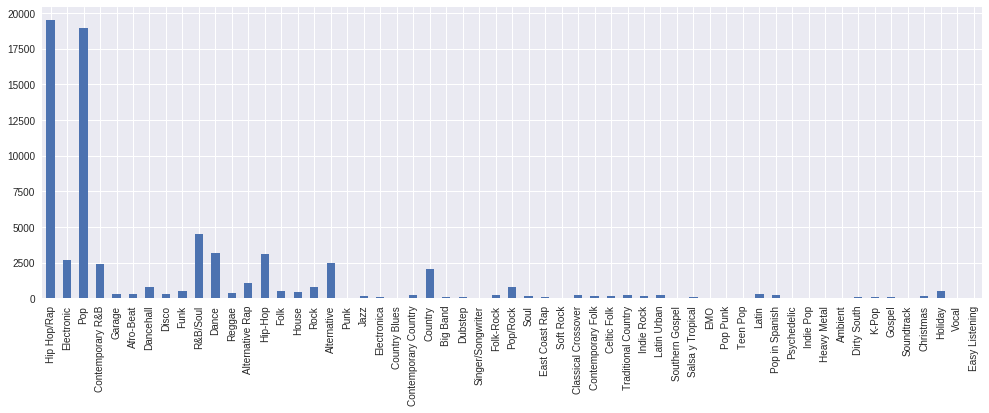

In [100]:
plt.style.use('seaborn')
genre_series = pd.Series(genre_counts)
genre_series.plot(kind='bar', figsize=(15, 5))